In [ ]:
# !pip install pandas==1.3.4
# !pip install mlflow==1.20.2
# !pip install lightgbm==3.3.1
# !pip install matplotlib==3.4.3
# !pip install catboost==1.0.3
# !pip install SQLAlchemy==1.4.25
# !pip install typing-extensions==3.10.0.0
# !pip install prompt-toolkit==3.0.5
# !pip install -r /kfs_private/requirements.txt
# !pip install -i https://test.pypi.org/simple/ kaml==1.0

# !pip install "pyarrow>=4.0.0" --prefer-binary
# !pip uninstall pyspark -y

## import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import base64
import os
import mlflow
from transformations import *

from kaml.client import *
from kaml.classification import *
import json
import base64


## Parameters

In [3]:
pd.set_option('display.max_columns',120)


def decode_py(message):
    base64_bytes = message.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    return message_bytes.decode('ascii')

def encode_py(message):
    message_bytes = message.encode('ascii')
    base64_bytes = base64.b64encode(message_bytes)
    return base64_bytes.decode('ascii')

with open('passcodes.json','r') as f:
    passcodes = json.load(f)
    
# set environment variable
os.environ['MLFLOW_S3_ENDPOINT_URL'] = decode_py(
    passcodes['MLFLOW_S3_ENDPOINT_URL']
)

os.environ['AWS_ACCESS_KEY_ID'] = decode_py(
    passcodes['AWS_ACCESS_KEY_ID']
)

os.environ['AWS_SECRET_ACCESS_KEY'] = decode_py(
    passcodes['AWS_SECRET_ACCESS_KEY']
)

os.environ['MLFLOW_BASE_URL'] = decode_py(
    passcodes['MLFLOW_BASE_URL']
)

mlflow.set_tracking_uri(os.environ['MLFLOW_BASE_URL'])
client = mlflow.tracking.MlflowClient(os.environ['MLFLOW_BASE_URL'])

MINIO_HOST='http://mlflow-minio-service.mlflow.svc.cluster.local:9000'
MINIO_ACCESS_KEY="minio"
MINIO_SECRET_KEY="BS6PpUKnW^Bkc@$l$QAsY$p#l"
MINIO_MODEL_BUCKET="models"

exp_name = "tpl_flg_no_hyrrach"

## Functions

### Read Parent Complaint file with columns that are filled during a complaint

In [4]:
#complaints_df_1 = pd.read_csv("parent_complaint_file.csv")

In [5]:
#complaints_df_1.columns

## Read Hierarchy Data

In [6]:
#hierarchy_df = pd.read_csv("bp_hierarchy_file.csv")

In [7]:
#complaints_hierarchy_df = pd.read_csv("cmplt_hrchy_file.csv")
cmplts_hrchy_df = pd.read_csv("cmplt_hrchy_file.csv")

In [8]:
cmplts_hrchy_df.columns

Index(['parent_reg_date', 'parent_reg__time', 'parent_complaint_number',
       'parent_business_partner', 'parent_msp_circuit',
       'parent_msp_circuit_description', 'parent_final_obs__code_group',
       'parent_final_obs__code', 'parent_mru', 'parent_industry',
       'parent_industry_system', 'parent_affected_bp',
       'parent_restoration_duration', 'parent_mode', 'parent_regi__group',
       'parent_regi__code', 'parent_rate_category', 'parent_bp_classification',
       'parent_account_class', 'parent_location', 'parent_sub_station',
       'parent_area', 'parent_responsible_zone', 'parent_responsible_dept',
       'parent_zone', 'parent_fsp_circuit', 'parent_fsp_circuit_description',
       'parent_affected_func__location', 'hrcrhy_zone', 'hrcrhy_portion',
       'hrcrhy_business_partner', 'hrcrhy_11kv_oh_feeder_cb',
       'hrcrhy_11kv_ug_feeder_cb', 'hrcrhy_22_kv_feeder',
       'hrcrhy_22_kv_sub_feeder', 'hrcrhy_ht_customer_ss',
       'hrcrhy_dist__sub_station', 'hrcrhy_

### Feature Set Label: New dependent variable: FLG(Functional Location Group)

In [9]:
cmplts_hrchy_df['flg'] = create_label(cmplts_hrchy_df)

In [10]:
cmplts_hrchy_df['flg'].unique()

array(['not_in_hierarchy', 'msp_circuit', 'delivery_point', 'bbc_ahd_',
       'dfsp_circuit', 'ottp', 'fsp_circuit', 'dist_transformer',
       'dist__box', 'msp', 'ht_customer_ss', 'lt_sw_fuse_unit',
       'dfsp_sub_circuit', 'fsp_sub_circuit', 'fsp', 'dfsp',
       'dist__sub_station', 'device_location'], dtype=object)

#### Removing those rows whose affected functional location is not in any hirearchical FLG

In [12]:
cmplts_hrchy_df=cmplts_hrchy_df[cmplts_hrchy_df['flg']!='not_in_hierarchy']

In [13]:
cmplts_hrchy_df.shape 

(73236, 55)

## Filling Missing Values

In [14]:
cmplts_hrchy_df['parent_reg__time'] = fill_parent_reg__time(cmplts_hrchy_df)
cmplts_hrchy_df['parent_rate_category'] = fill_parent_rate_category(cmplts_hrchy_df)

## Format Data

In [15]:
cmplts_hrchy_df['parent_reg_date_time'] = format_parent_reg_date(cmplts_hrchy_df)

## Feature Creation

In [16]:
cmplts_hrchy_df = date_time_features(cmplts_hrchy_df,"parent_reg_date_time")

## Historical Feature Creation

### Feature 1: No of times the AFL is affected in past

In [18]:
cmplts_hrchy_df['no_of_times_asset_affected'] = no_of_times_asset_affected(cmplts_hrchy_df)

### Feature 2: When was the last time the asset was affected

In [20]:
cmplts_hrchy_df['days_when_asset_last_affected'] = days_when_asset_last_affected(cmplts_hrchy_df)

### Feature 3: Number of times hierarchy asset affected in past

In [22]:
hierarchy_cols = ['hrcrhy_11kv_oh_feeder_cb','hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder','hrcrhy_22_kv_sub_feeder','hrcrhy_ht_customer_ss',
                  'hrcrhy_dist__sub_station','hrcrhy_dist_transformer','hrcrhy_fsp','hrcrhy_fsp_circuit','hrcrhy_fsp_sub_circuit','hrcrhy_dfsp',
                  'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit','hrcrhy_msp','hrcrhy_msp_circuit','hrcrhy_otdp','hrcrhy_ottp','hrcrhy_lt_sw_fuse_unit',
                  'hrcrhy_delivery_point','hrcrhy_bbc_ahd_','hrcrhy_dist__box','hrcrhy_device_location']

In [23]:
for col in hierarchy_cols:
    cmplts_hrchy_df = hierarchy_asset_affected(cmplts_hrchy_df,col)

## Feature Set 4: Number of days before a particular asset was affected

In [25]:
for col in hierarchy_cols:
    cmplts_hrchy_df = noof_days_before_asset_affected(cmplts_hrchy_df,col)

###  Feature 5: whether customer is HT customer or not

In [26]:
cmplts_hrchy_df['is_parent_ht_customer'] = is_parent_ht_customer(cmplts_hrchy_df)

### Feature 5: Average of affected BP in past for business partner

In [29]:
cmplts_hrchy_df['average_affected_bp'] = average_affected_bp(cmplts_hrchy_df)

### Feature 6: Median of affected BP in past for business partner

In [31]:
cmplts_hrchy_df['median_affected_bp_past'] = median_affected_bp_past(cmplts_hrchy_df)

### Feature 7: Number of complaints in the past for business partner

In [33]:
cmplts_hrchy_df['no_of_complaints_for_bp_past'] = no_of_complaints_for_bp_past(cmplts_hrchy_df)

In [35]:
#cmplts_hrchy_df.to_csv('cmplt_hrchy_all_features.csv',index=False)

### Child data read and merge

In [36]:
child_comp_df =  pd.read_excel("Child Complaint Details.xlsb")

In [37]:
child_comp_df.columns = rename_columns(child_comp_df,suffix="child_")

In [38]:
cmplts_hrchy_chld_df = cmplts_hrchy_df.merge(child_comp_df, left_on=['parent_complaint_number'],right_on=['child_parent_complaint'],how='inner')

## Child Data Cleaning

In [40]:
cmplts_hrchy_chld_df['child_reg_date_time'] = format_child_reg_date(cmplts_hrchy_chld_df)
cmplts_hrchy_chld_df['parent_area'] = fill_parent_area(cmplts_hrchy_chld_df[['parent_area']])
cmplts_hrchy_chld_df['parent_mru'] = fill_parent_mru(cmplts_hrchy_chld_df[['parent_mru']])

## Feature Creation

In [41]:
cmplts_hrchy_chld_df = date_time_features(cmplts_hrchy_chld_df,'child_reg_date_time')

In [43]:
cmplts_hrchy_chld_df['time_diff_btwn_child_parent_cmplt'] = time_diff_btwn_child_parent_cmplt(cmplts_hrchy_chld_df)

In [45]:
cmplts_hrchy_chld_df['no_of_past_child_cmplt'] = no_of_past_child_cmplt(cmplts_hrchy_chld_df)

In [46]:
cmplts_hrchy_chld_df['child_vip_flag']=child_vip_flag(cmplts_hrchy_chld_df[['child_vip_flag']])

In [47]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']
#hierarchy_list.reverse()
def common_hrcrhy_level_of_child_parent(df):
    return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == str(df[y+"_child"]),hierarchy_list)))[0]
    #hierarchy_temp_df = hierarchy_df[hierarchy_df['hrcrhy_business_partner']==df['child_partner_no']]
#     if not hierarchy_temp_df.empty:
#         return list(map(lambda x: x, filter(lambda y: str(df[y+"_parent"]) == df[y+"_child"].values[0],hierarchy_list)))[0]
#     else:
#         return np.NaN
#     for i in hierarchy_list:
#         if hierarchy_temp_df[i].empty:
#             return np.NaN
#         if str(df[i]) == hierarchy_temp_df[i].values[0]:
#             return i
#     return np.NaN

# temp_child_hrrcy = cmplts_hrchy_chld_df.merge(hierarchy_df,left_on='child_partner_no',right_on='hrcrhy_business_partner',suffixes=('_parent','_child'))
# temp_child_hrrcy.apply(common_hrcrhy_level_of_child_parent,axis=1).unique()

In [48]:
# cmplts_hrchy_chld_df.to_csv("child_cmplt_hrchy.csv",index=False)

In [49]:
# cmplts_hrchy_chld_df=pd.read_csv("child_cmplt_hrchy.csv")

## Split Train, Test and Validation Data

In [50]:
## train_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-07-01')]
## validation_data = complaints_hierarchy_df[(complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-07-01')) & (complaints_hierarchy_df['reg_date_time'] < pd.to_datetime('2021-10-01'))]
## test_data = complaints_hierarchy_df[complaints_hierarchy_df['reg_date_time'] >= pd.to_datetime('2021-10-01')]

### Taking only 1st year data for training where number of child complaints > cmplnt_fmly_crtcl_mass

In [134]:
from sklearn.model_selection import train_test_split

train_val_data_all_cmplt = cmplts_hrchy_chld_df[pd.to_datetime(cmplts_hrchy_chld_df['parent_reg_date_time']) < pd.to_datetime('2021-07-01')]
test_data = cmplts_hrchy_chld_df[pd.to_datetime(cmplts_hrchy_chld_df['parent_reg_date_time']) >= pd.to_datetime('2021-07-01')]



In [135]:
cmplnt_fmly_crtcl_mass = 1

In [136]:
#train_val_data = train_val_data[train_val_data.groupby('complaint_number').size()>cmplnt_fmly_crtcl_mass]

train_val_data = train_val_data_all_cmplt[train_val_data_all_cmplt.groupby(['parent_complaint_number'])['child_partner_no'].transform('count')>cmplnt_fmly_crtcl_mass]

In [137]:
train_val_data.shape

(25652, 270)

In [138]:
#train_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.head(cmplnt_fmly_crtcl_mass)).reset_index(drop=True)
val_data = train_val_data.sort_values('child_reg_date_time').groupby('parent_complaint_number').tail(1)
train_data = train_val_data.sort_values('child_reg_date_time').groupby('parent_complaint_number',as_index=False).apply(lambda x: x.iloc[:-1])

In [139]:
train_data.shape

(15994, 270)

In [140]:
val_data.shape

(9658, 270)

In [143]:
#val_data = train_val_data.groupby(['parent_complaint_number']).apply(lambda x: x.iloc[cmplnt_fmly_crtcl_mass:,:]).reset_index(drop=True)

In [146]:
from sklearn.model_selection import train_test_split
# train_data, validation_data = train_test_split(train_val_data,test_size=0.2,random_state=42)

In [147]:
#train_val_data, test_data = train_test_split(cmplts_hrchy_chld_df,test_size=0.2,random_state=42)
#train_data, val_data = train_test_split(train_val_data,test_size=0.2,random_state=42)

In [148]:
print("Train Data : ", train_data.shape)
print("Validation Data : ", val_data.shape)
print("Test Data : ", test_data.shape)

Train Data :  (15994, 270)
Validation Data :  (9658, 270)
Test Data :  (8819, 270)


In [149]:
len(train_data['flg'].unique())

15

In [150]:
len(val_data['flg'].unique())

15

In [151]:
len(test_data['flg'].unique())

16

## Drop Un-used features

In [152]:
child_cmplt_feat = ['portion','mru','object_id','regio_group','name','address','registration_date','registration_time','area',
 'affected_fl','affected_fl_count','allocation_date','allocation_time','allocation_duration',
 'attending_date','attending_time','attending_duration','created_by','diverted_dept','diverted_zone','faultman','faultman_id',
 'mode','responsible_dept','responsible_zone','status','system_condition','technician_remark','temp_date','temp_time','perm_date',
 'perm_time','temp_duration','perm_duration','observation_codegroup','observation_code','final_observation_codegroup_mains_',
 'final_observation_code_mains_','category_1','category_2','power_restoration','mobile_no','sub_station','sub_station_name','feeder',
 'feeder_name','notification_no_yz_','location','planner_group','work_center','note1','note2','gross__duration','compliance_duration',
 'restoration_duration__min_','atteding_dur_from_allocation','within_internal_benchmark','internal_benchmark_def','npc_compliance',
 'neg_ind','final_observation','final_observation_code','complaint_group','rnpc_complaint','solved_by_rnpc','damage_memo_amt',
 'old_categ_1','old_categ_2','power_on_site','dtc_code','dtc_name','delivery_point','del_name','meter_no','service_status','repeat_call',
 'rnpc_visit_id','rnpc_visit_name','rate_cateogry','sanction_load','connected_load','bill_class','phase','mf','attended_user_id',
 'attended_user_name','mobile_no_1','mobile_no_2','notification_no_y9_','pending_in_minute','hv_notification','compliance_st_date',
 'compliance_st_time','compliance_end_date','compliance_end_time','diverted_date','diverted_time','reading_seq_no','legacy_seq_no',
 'direction','old_info','theft_ind','master_mobile_no_1','master_mobile_no_2','master_mobile_no_3','master_mobile_no_4','first_allocation_date',
 'first_allocation_time','actual_completion_date','actual_completion_time','creator_zone','creator_dept','npc_compliance_reason',
 'npc_compliance_reason_1','entered_attending_date','entered_attending_time','complainer_name','changed_by','changed_from',
 'act_comp_st_date','act_comp_st_time','act_comp_en_date','act_comp_en_time','old_tech_remark','amp_rating',
 'cause_code_group','cause_code','damage_code_group','damage_code','object_code_group','object_code','ckt_phase',
 'same_circuit_npc','last_reading','last_reading_date','manufacturer_serial_no','allocated_user_id','allocated_user_name','service_category']

In [153]:
child_cmplt_feat = ["child_"+x for x in child_cmplt_feat]

In [154]:
drop_columns = ['parent_reg__time','parent_industry','parent_industry_system','parent_reg_date','parent_reg_date_time','child_reg_date_time','parent_affected_bp','parent_restoration_duration','parent_final_obs__code','parent_msp_circuit_description','parent_affected_func__location','hrcrhy_count',
               'parent_fsp_circuit_description','parent_mode','parent_responsible_zone','parent_responsible_dept','child_portion',
                'parent_final_obs__code_group','child_description','days_when_asset_last_affected',
 'no_of_times_asset_affected',]+child_cmplt_feat

In [155]:
train_data.drop(drop_columns,axis=1,inplace=True)
val_data.drop(drop_columns,axis=1,inplace=True)
test_data.drop(drop_columns,axis=1,inplace=True)

## Label Encode

In [156]:
label_encode_list = ['parent_msp_circuit','parent_fsp_circuit','parent_account_class','parent_mru','parent_location','parent_regi__group','parent_regi__code','parent_rate_category','parent_bp_classification',
                    'parent_area','parent_regi__group','hrcrhy_11kv_oh_feeder_cb','hrcrhy_11kv_ug_feeder_cb', 'hrcrhy_22_kv_feeder','hrcrhy_22_kv_sub_feeder', 'hrcrhy_dist__sub_station',
                    'hrcrhy_dist_transformer', 'hrcrhy_fsp','parent_sub_station','parent_zone','hrcrhy_dfsp', 'hrcrhy_otdp','hrcrhy_ht_customer_ss','hrcrhy_fsp_circuit',
                    'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit', 'hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_portion','hrcrhy_zone',
                    'hrcrhy_device_location','hrcrhy_dfsp_circuit', 'hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp','hrcrhy_fsp_sub_circuit','hrcrhy_msp_circuit',]

In [157]:
label_encoding_fit(train_data,label_encode_list)

In [158]:
train_data= label_encoding_transfrom(train_data)
val_data=label_encoding_transfrom(val_data)
test_data=label_encoding_transfrom(test_data)

#### LabelEncode

In [162]:
train_data['flg'] = label_mapping(train_data[['flg']])
val_data['flg'] = label_mapping(val_data[['flg']])
test_data['flg'] = label_mapping(test_data[['flg']])

## Feature Selection

In [163]:
#train_data.to_csv("child_train_data.csv",index=False)

In [164]:
#val_data.to_csv("child_val_data.csv",index=False)

In [165]:
#test_data.to_csv("child_test_data.csv",index=False)

In [166]:
#train_data = pd.read_csv("child_train_data.csv")

In [167]:
#val_data = pd.read_csv("child_val_data.csv")

In [168]:
#test_data= pd.read_csv("child_test_data.csv")

## remove hierarchy features

In [169]:
hierarchy_list = ['hrcrhy_11kv_oh_feeder_cb', 'hrcrhy_11kv_ug_feeder_cb','hrcrhy_22_kv_feeder', 'hrcrhy_22_kv_sub_feeder',
       'hrcrhy_ht_customer_ss', 'hrcrhy_dist__sub_station','hrcrhy_dist_transformer', 'hrcrhy_fsp', 'hrcrhy_fsp_circuit',
       'hrcrhy_fsp_sub_circuit', 'hrcrhy_dfsp', 'hrcrhy_dfsp_circuit','hrcrhy_dfsp_sub_circuit', 'hrcrhy_msp', 'hrcrhy_msp_circuit',
       'hrcrhy_otdp', 'hrcrhy_ottp', 'hrcrhy_lt_sw_fuse_unit','hrcrhy_delivery_point', 'hrcrhy_bbc_ahd_', 'hrcrhy_dist__box','hrcrhy_device_location']

In [170]:
id_columns = ["parent_complaint_number","parent_business_partner",'child_partner_no','child_parent_complaint','hrcrhy_business_partner']
use_cols = list(set(train_data.columns) - set(id_columns) - set(hierarchy_list))

## Univarient Features selection

In [171]:
sel_cols = univarient_selection(train_data[use_cols])

## Correlation Features selection

In [172]:
sel_cols = correlation_feature_elemination(train_data[sel_cols])

In [173]:
label ='flg'

In [174]:
X_train = train_data[sel_cols].drop(label,axis=1)
y_train = train_data[label]
X_val =  val_data[sel_cols].drop(label,axis=1)
y_val =  val_data[label]
 

## Mutual Info feature selection

In [175]:
top_features_mu_info = mutual_info_score(X_train,y_train)

## Recursive Feature Engineering

In [176]:
top_features_rfe = recursive_feature_engineering(X_train, y_train)

In [177]:
top = top_features_rfe
top

['parent_reg_date_time_periodofday',
 'median_affected_bp_past',
 'parent_area',
 'parent_sub_station',
 'parent_mru',
 'parent_fsp_circuit',
 'time_diff_btwn_child_parent_cmplt',
 'hrcrhy_fsp_circuit_noof_days_before_affected_in_past',
 'parent_zone',
 'parent_reg_date_time_day',
 'parent_msp_circuit',
 'parent_bp_classification',
 'parent_location',
 'parent_reg_date_time_dayofweek',
 'parent_reg_date_time_minute',
 'child_reg_date_time_periodofday',
 'child_reg_date_time_minute',
 'hrcrhy_portion',
 'child_reg_date_time_month',
 'hrcrhy_fsp_circuit_noof_times_affected_in_past']

In [178]:
X_train = train_data[top]
y_train = train_data[label]

X_val = val_data[top]
y_val = val_data[label]

## PCA

In [179]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_val = pca.transform(X_val)
# #X_test = pca.transform(X_test)

In [180]:
# pca.explained_variance_ratio_

In [181]:
# X_test =  test_data[sel_cols].drop(label,axis=1)
# y_test =  test_data[label]
# X_test = pca.transform(X_test)

## Shaply

In [182]:
# import shap
# from xgboost import XGBClassifier
# model = XGBClassifier(n_estimators=1000, max_depth=10,learning_rate=0.001)
# model.fit(X_train,y_train)

# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_val)

In [183]:
# i = 10
# shap.force_plot(explainer.expected_value,shap_values[i], features=X_test.iloc[i], features_names=X_test.columns)

In [184]:
# shap.summary_plot(shap_values, features=X_val, feature_names=X_val.columns)

In [185]:
# shap.summary_plot(shap_values, features=X_val, feature_name=X_val.columns, plot_type='bar')

## Modelling

In [262]:
clf = Classifier(X_train,X_val,y_train,y_val, exp_name, multiclass=True, average="weighted")

In [263]:
exp_id = clf.id
print("experiment name : ",clf.name)
print("experiment location : ",clf.location)
print("experiment id : ",clf.id)
print("experiment status : ",clf.stage)

experiment name :  tpl_flg_no_hyrrach
experiment location :  s3://models/3
experiment id :  3
experiment status :  active


In [264]:
run_list = clf.search_runs(exp_id)['run_id'].tolist()
if run_list:
    clf.delete_run_by_id(run_list)

In [265]:
clf.LogisticRegression()

In [266]:
clf.GradientBoostingClassifier()

In [267]:
clf.RandomForestClassifier(is_tune=True,params=params_dict)

[I 2022-03-01 07:29:36,642] A new study created in memory with name: no-name-dc617813-46d0-4257-a057-03636012a588
[I 2022-03-01 07:29:54,875] Trial 0 finished with value: 0.734520604680058 and parameters: {'bootstrap': 1, 'max_depth': 100, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 500}. Best is trial 0 with value: 0.734520604680058.
[I 2022-03-01 07:30:03,620] Trial 1 finished with value: 0.6895837647546076 and parameters: {'bootstrap': 1, 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 300}. Best is trial 0 with value: 0.734520604680058.
[I 2022-03-01 07:30:11,123] Trial 2 finished with value: 0.6592462207496376 and parameters: {'bootstrap': 1, 'max_depth': 80, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 100}. Best is trial 0 with value: 0.734520604680058.
[I 2022-03-01 07:30:30,942] Trial 3 finished with value: 0.7072892938496583 and parameters: {'bootst

Number of finished trials:  5
Best trial:
  accuracy score:  0.734520604680058
  Params: 
    bootstrap: 1
    max_depth: 100
    max_features: 4
    min_samples_leaf: 3
    min_samples_split: 12
    n_estimators: 500


In [268]:
clf.AdaBoostClassifier()

In [269]:
clf.LGBMClassifier()

In [270]:
clf.XGBClassifier()

[07:31:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [271]:
clf.DecisionTreeClassifier()

In [272]:
clf.RidgeClassifier()

In [273]:
clf.KNeighborsClassifier()

In [274]:
clf.GaussianNB()

In [275]:
clf.CatBoostClassifier()

Learning rate set to 0.091143
0:	learn: 2.4570822	total: 27.7ms	remaining: 27.7s
1:	learn: 2.3045145	total: 51.4ms	remaining: 25.7s
2:	learn: 2.2018350	total: 77.2ms	remaining: 25.6s
3:	learn: 2.1220779	total: 118ms	remaining: 29.4s
4:	learn: 2.0575214	total: 150ms	remaining: 29.9s
5:	learn: 2.0037659	total: 205ms	remaining: 33.9s
6:	learn: 1.9557204	total: 261ms	remaining: 37s
7:	learn: 1.9159497	total: 312ms	remaining: 38.7s
8:	learn: 1.8831124	total: 352ms	remaining: 38.8s
9:	learn: 1.8499477	total: 393ms	remaining: 38.9s
10:	learn: 1.8213847	total: 422ms	remaining: 37.9s
11:	learn: 1.7987190	total: 447ms	remaining: 36.8s
12:	learn: 1.7747577	total: 470ms	remaining: 35.7s
13:	learn: 1.7543031	total: 496ms	remaining: 34.9s
14:	learn: 1.7392060	total: 524ms	remaining: 34.4s
15:	learn: 1.7250796	total: 557ms	remaining: 34.3s
16:	learn: 1.7117181	total: 591ms	remaining: 34.2s
17:	learn: 1.7009114	total: 620ms	remaining: 33.8s
18:	learn: 1.6907859	total: 645ms	remaining: 33.3s
19:	learn:

## Get runs

In [276]:
# Select the run of the experiment
df_runs = clf.search_runs(clf.id)
print("Number of runs done : ", len(df_runs))
df_runs.head()

Number of runs done :  16


artifact_uri  \
0  s3://models/3/cbf9d11c2fdb4685bc91bcf2398a8762...   
1  s3://models/3/34a1ebd7fa6c499db9a445272405a3f8...   
2  s3://models/3/6346249ee920450b8256895fd2df4587...   
3  s3://models/3/2329ffe76cc948729e12c315167c601d...   
4  s3://models/3/3bbd9cab54f84824b797c555ed6ac5d7...   

                          end_time experiment_id  metrics.accuracy_score  \
0 2022-03-01 07:31:59.266000+00:00             3                0.825740   
1 2022-03-01 07:31:28.882000+00:00             3                0.263512   
2 2022-03-01 07:31:27.244000+00:00             3                0.600745   
3 2022-03-01 07:31:22.131000+00:00             3                0.429178   
4 2022-03-01 07:31:20.468000+00:00             3                0.692172   

   metrics.f1_score  metrics.precision_score  metrics.recall params.bootstrap  \
0          0.823238                 0.841335        0.825740             None   
1          0.269982                 0.382262        0.263512             None   
2          0.582999                 0.599645        0.600745             None   
3          0.307253                 0.311341        0.429178             None   
4          0.694593                 0.700270        0.692172             None   

  params.max_depth params.max_features params.min_samples_leaf  \
0             None                None                    None   
1             None                None                    None   
2             None                None                    None   
3             None                None                    None   
4             None                None                    None   

  params.min_samples_split params.n_estimators  \
0                     None                None   
1                     None                None   
2                     None                None   
3                     None                None   
4                     None                None   

                             run_id  \
0  cbf9d11c2fdb4685bc91bcf2398a8762   
1  34a1ebd7fa6c499db9a445272405a3f8   
2  6346249ee920450b8256895fd2df4587   
3  2329ffe76cc948729e12c315167c601d   
4  3bbd9cab54f84824b797c555ed6ac5d7   

                                        run_name  \
0      tpl_flg_no_hyrrach_3_cat_boost_classifier   
1    tpl_flg_no_hyrrach_3_gaussian_NB_classifier   
2    tpl_flg_no_hyrrach_3_k_neighbors_classifier   
3          tpl_flg_no_hyrrach_3_ridge_classifier   
4  tpl_flg_no_hyrrach_3_decision_tree_classifier   

                        start_time    status  \
0 2022-03-01 07:31:28.901000+00:00  FINISHED   
1 2022-03-01 07:31:27.260000+00:00  FINISHED   
2 2022-03-01 07:31:22.147000+00:00  FINISHED   
3 2022-03-01 07:31:20.484000+00:00  FINISHED   
4 2022-03-01 07:31:18.543000+00:00  FINISHED   

                       tags.mlflow.log-model.history tags.mlflow.parentRunId  
0  [{"run_id": "cbf9d11c2fdb4685bc91bcf2398a8762"...                    None  
1  [{"run_id": "34a1ebd7fa6c499db9a445272405a3f8"...                    None  
2  [{"run_id": "6346249ee920450b8256895fd2df4587"...                    None  
3  [{"run_id": "2329ffe76cc948729e12c315167c601d"...                    None  
4  [{"run_id": "3bbd9cab54f84824b797c555ed6ac5d7"...                    None

## Evaluating  Models

In [277]:
top_runs = df_runs.sort_values(['metrics.accuracy_score'],ascending=False)
top_runs.head()

artifact_uri  \
13  s3://models/3/484a4818c60247729266fa6ae5a113bf...   
5   s3://models/3/2506a1b9e34e478685a545a09af471ab...   
0   s3://models/3/cbf9d11c2fdb4685bc91bcf2398a8762...   
6   s3://models/3/22cb799cf0ea4f0f891c6136d0ee747a...   
12  s3://models/3/59db2a8562de47a380593efea9e5f30a...   

                           end_time experiment_id  metrics.accuracy_score  \
13 2022-03-01 07:30:54.841000+00:00             3                0.925347   
5  2022-03-01 07:31:18.523000+00:00             3                0.872023   
0  2022-03-01 07:31:59.266000+00:00             3                0.825740   
6  2022-03-01 07:31:02.990000+00:00             3                0.795817   
12 2022-03-01 07:29:54.853000+00:00             3                0.734521   

    metrics.f1_score  metrics.precision_score  metrics.recall  \
13          0.925280                 0.932077        0.925347   
5           0.871569                 0.881219        0.872023   
0           0.823238                 0.841335        0.825740   
6           0.795993                 0.814600        0.795817   
12          0.706068                 0.785253        0.734521   

   params.bootstrap params.max_depth params.max_features  \
13             None             None                None   
5              None             None                None   
0              None             None                None   
6              None             None                None   
12                1              100                   4   

   params.min_samples_leaf params.min_samples_split params.n_estimators  \
13                    None                     None                None   
5                     None                     None                None   
0                     None                     None                None   
6                     None                     None                None   
12                       3                       12                 500   

                              run_id  \
13  484a4818c60247729266fa6ae5a113bf   
5   2506a1b9e34e478685a545a09af471ab   
0   cbf9d11c2fdb4685bc91bcf2398a8762   
6   22cb799cf0ea4f0f891c6136d0ee747a   
12  59db2a8562de47a380593efea9e5f30a   

                                             run_name  \
13      tpl_flg_no_hyrrach_3_random_forest_classifier   
5                 tpl_flg_no_hyrrach_3_xgb_classifier   
0           tpl_flg_no_hyrrach_3_cat_boost_classifier   
6                tpl_flg_no_hyrrach_3_lgbm_classifier   
12  tpl_flg_no_hyrrach_3_random_forest_classifier_...   

                         start_time    status  \
13 2022-03-01 07:29:30.126000+00:00  FINISHED   
5  2022-03-01 07:31:03.009000+00:00  FINISHED   
0  2022-03-01 07:31:28.901000+00:00  FINISHED   
6  2022-03-01 07:30:57.784000+00:00  FINISHED   
12 2022-03-01 07:29:36.646000+00:00  FINISHED   

                        tags.mlflow.log-model.history  \
13  [{"run_id": "484a4818c60247729266fa6ae5a113bf"...   
5   [{"run_id": "2506a1b9e34e478685a545a09af471ab"...   
0   [{"run_id": "cbf9d11c2fdb4685bc91bcf2398a8762"...   
6   [{"run_id": "22cb799cf0ea4f0f891c6136d0ee747a"...   
12  [{"run_id": "59db2a8562de47a380593efea9e5f30a"...   

             tags.mlflow.parentRunId  
13                              None  
5                               None  
0                               None  
6                               None  
12  484a4818c60247729266fa6ae5a113bf

## Selecting best model

In [278]:
artifacts = top_runs.iloc[0]["artifact_uri"]
run_id = top_runs.iloc[0]["run_id"]
model_name = top_runs.iloc[0]["run_name"] 


print('Best model_artifacts :',artifacts)
print("=" * 100)
print('Best model run_id :',run_id)
print("=" * 100)
print('Best model :',model_name)
print("=" * 100)
print("Best model experiment id :",clf.id)

Best model_artifacts : s3://models/3/484a4818c60247729266fa6ae5a113bf/artifacts
Best model run_id : 484a4818c60247729266fa6ae5a113bf
Best model : tpl_flg_no_hyrrach_3_random_forest_classifier
Best model experiment id : 3


## Model Performance Matrices

## Load Best Model

In [249]:

location = artifacts + "/" + model_name
best_model = clf.load_model(location)

best_model.fit(X_train,y_train)

RandomForestClassifier()

In [250]:
# import joblib
# joblib.dump(best_model,"best_model.joblib")

In [251]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import SVC

# best_model = OneVsRestClassifier(SVC()).fit(X_train,y_train)

## Train Performance

In [252]:
label_list = y_train.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 1.0
recall:  1.0
f1_scr:  1.0
precision_score:  1.0
Classification Report 
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00       680
           7       1.00      1.00      1.00       129
           8       1.00      1.00      1.00      6651
           9       1.00      1.00      1.00       337
          10       1.00      1.00      1.00        38
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00        71
          13       1.00      1.00      1.00      1570
          14       1.00      1.00      1.00      2176
          16       1.00      1.00      1.00       757
          17       1.00      1.00      1.00       303
          18       1.00      1.00      1.00      2631
          19       1.00      1.00      1.00       232
          20       1.00      1.00      1.00       149

    accuracy                           1.0

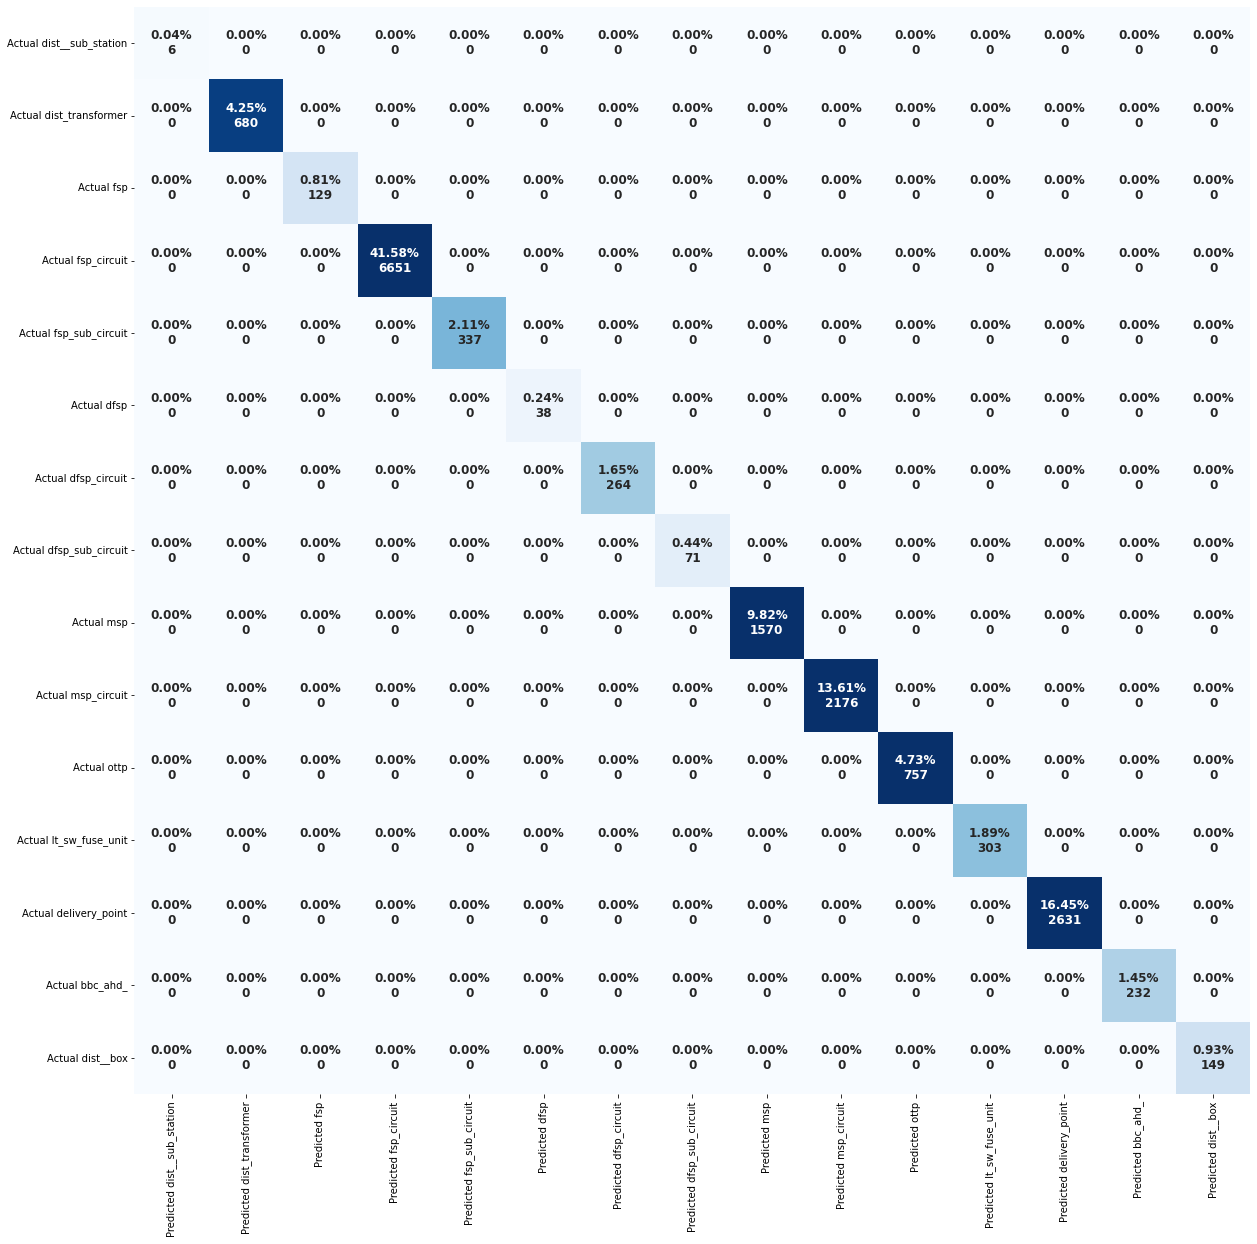

In [253]:
performance_matices(best_model, X_train, y_train, label_list)


## Validation Performance

In [254]:
label_list = y_val.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 0.9134396355353075
recall:  0.9134396355353075
f1_scr:  0.9129721344851419
precision_score:  0.9208462749431634
Classification Report 
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         3
           6       0.99      0.89      0.94       399
           7       0.98      0.83      0.90        71
           8       0.93      0.97      0.95      3700
           9       1.00      0.82      0.90       197
          10       1.00      0.78      0.88        23
          11       1.00      0.88      0.94       146
          12       0.97      0.90      0.94        41
          13       0.99      0.83      0.90       907
          14       0.90      0.89      0.89      1397
          16       0.99      0.76      0.86       540
          17       0.98      0.77      0.86       217
          18       0.81      0.96      0.88      1736
          19       1.00      0.75      0.86       179
          20       1.00      0.72    

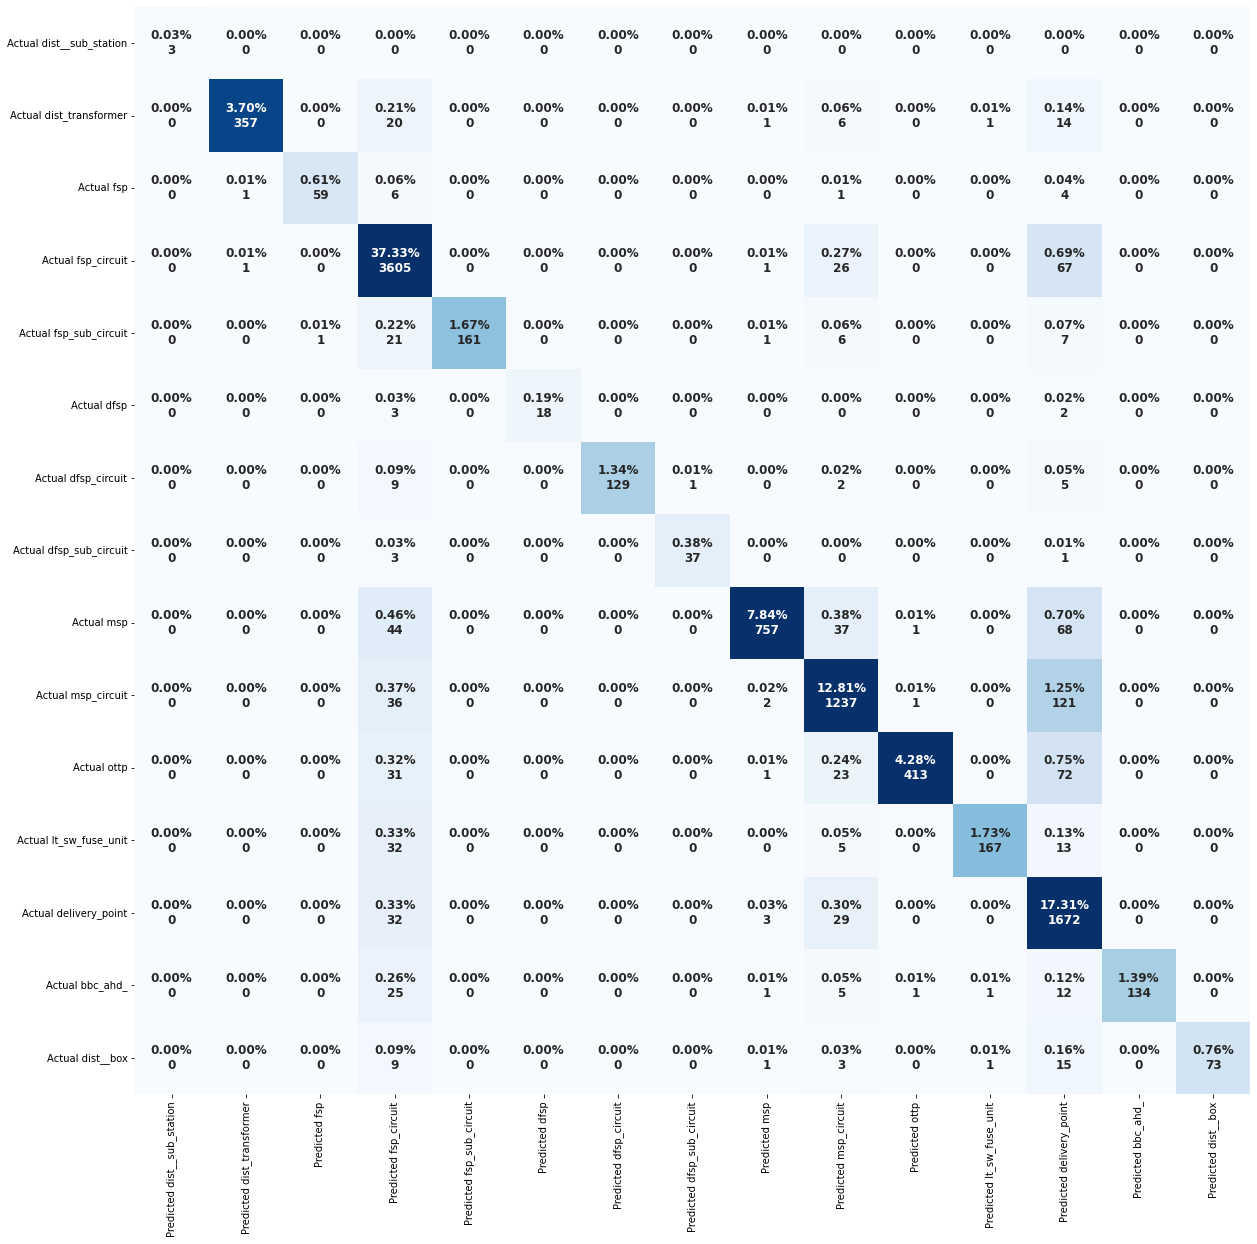

In [255]:
performance_matices(best_model, X_val, y_val, label_list)

## Test Performance

In [256]:
test_data.shape

(8819, 111)

In [257]:
test_data1 = test_data[test_data[label]!=21]

In [258]:
test_data1.shape

(8816, 111)

In [259]:
X_test = test_data1[X_val.columns]
y_test = test_data1[label]

In [260]:
label_list = y_test.unique().tolist()
label_list.sort()
label_list

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]

Accuracy Score : 0.41481397459165154
recall:  0.41481397459165154
f1_scr:  0.3318660819143127
precision_score:  0.3657655895723482
Classification Report 
              precision    recall  f1-score   support

           5       0.00      0.00      0.00        17
           6       0.22      0.03      0.06       399
           7       0.00      0.00      0.00        89
           8       0.47      0.82      0.60      3280
           9       0.38      0.01      0.03       216
          10       0.00      0.00      0.00        38
          11       0.00      0.00      0.00       126
          12       0.00      0.00      0.00        26
          13       0.23      0.01      0.02       869
          14       0.36      0.14      0.20      1385
          16       0.32      0.06      0.10       479
          17       0.15      0.21      0.17       242
          18       0.34      0.48      0.39      1353
          19       0.40      0.03      0.06       197
          20       1.00      0.02  

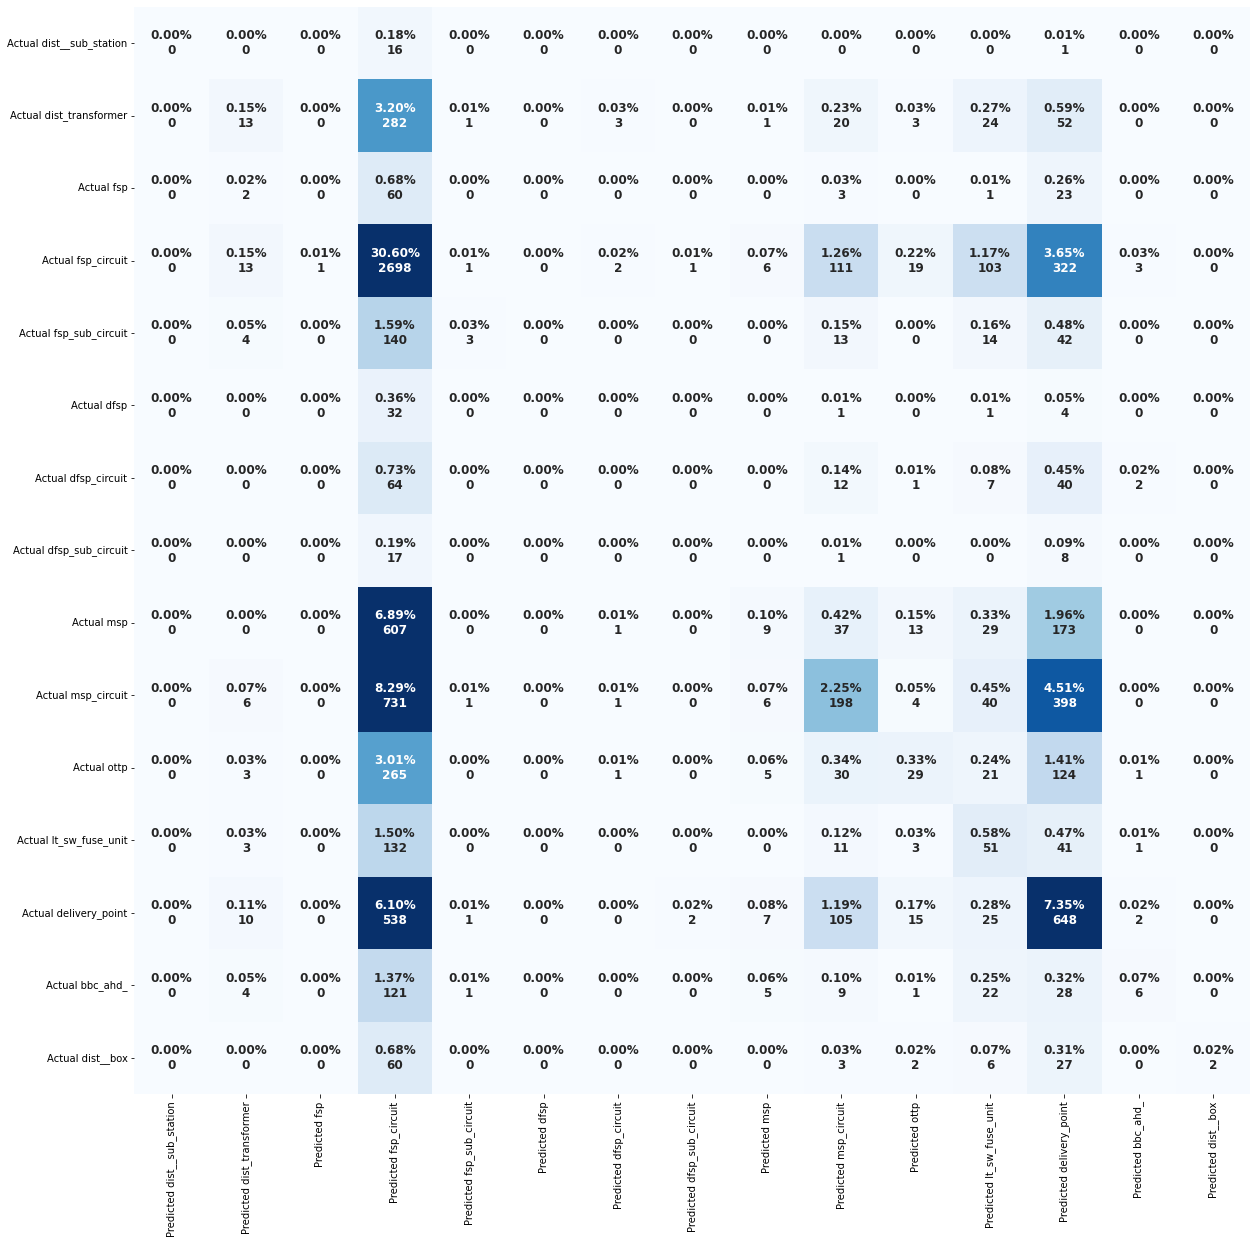

In [261]:
performance_matices(best_model, X_test, y_test,label_list)

In [217]:
y_test_pred = best_model.predict(X_test)
test_result = test_data1.copy()
test_result['flg_actual'] = y_test
test_result['flg_predict'] = y_test_pred

In [218]:
test_result[test_result['flg_actual']!=8].shape

(5536, 113)

In [219]:
test_result[test_result['flg_actual']==8].shape

(3280, 113)

In [220]:
test_result[test_result['flg_predict']!=8].shape

(3142, 113)

In [221]:
test_result[test_result['flg_predict']==8].shape

(5674, 113)

In [222]:
test_result[test_result['parent_complaint_number']==1006538854]

parent_complaint_number  parent_business_partner  parent_msp_circuit  \
43304              1006538854                  2168378                -1.0   
43305              1006538854                  2168378                -1.0   
43306              1006538854                  2168378                -1.0   
43307              1006538854                  2168378                -1.0   
43308              1006538854                  2168378                -1.0   
43309              1006538854                  2168378                -1.0   

       parent_mru  parent_regi__group  parent_regi__code  \
43304        -1.0                -1.0                  1   
43305        -1.0                -1.0                  1   
43306        -1.0                -1.0                  1   
43307        -1.0                -1.0                  1   
43308        -1.0                -1.0                  1   
43309        -1.0                -1.0                  1   

       parent_rate_category  parent_bp_classification  parent_account_class  \
43304                     2                         2                     2   
43305                     2                         2                     2   
43306                     2                         2                     2   
43307                     2                         2                     2   
43308                     2                         2                     2   
43309                     2                         2                     2   

       parent_location  parent_sub_station  parent_area  parent_zone  \
43304               28               467.0         36.0            3   
43305               28               467.0         36.0            3   
43306               28               467.0         36.0            3   
43307               28               467.0         36.0            3   
43308               28               467.0         36.0            3   
43309               28               467.0         36.0            3   

       parent_fsp_circuit  hrcrhy_zone  hrcrhy_portion  \
43304               522.0            3            66.0   
43305               522.0            3            66.0   
43306               522.0            3            66.0   
43307               522.0            3            66.0   
43308               522.0            3            66.0   
43309               522.0            3            66.0   

       hrcrhy_business_partner  hrcrhy_11kv_oh_feeder_cb  \
43304                  2168378                       1.0   
43305                  2168378                       1.0   
43306                  2168378                       1.0   
43307                  2168378                       1.0   
43308                  2168378                       1.0   
43309                  2168378                       1.0   

       hrcrhy_11kv_ug_feeder_cb  hrcrhy_22_kv_feeder  hrcrhy_22_kv_sub_feeder  \
43304                     341.0                    1                        1   
43305                     341.0                    1                        1   
43306                     341.0                    1                        1   
43307                     341.0                    1                        1   
43308                     341.0                    1                        1   
43309                     341.0                    1                        1   

       hrcrhy_ht_customer_ss  hrcrhy_dist__sub_station  \
43304                      1                     479.0   
43305                      1                     479.0   
43306                      1                     479.0   
43307                      1                     479.0   
43308                      1                     479.0   
43309                      1                     479.0   

       hrcrhy_dist_transformer  hrcrhy_fsp  hrcrhy_fsp_circuit  \
43304                    481.0       495.0               522.0   
43305                    481.0       495.0  

In [ ]:
temp = pd.DataFrame(test_result[test_result['flg_predict']!=8].groupby('parent_complaint_number')['parent_business_partner'].count())
temp[temp['parent_business_partner']>=3]

In [ ]:
test_data1.columns